In [9]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, ShuffleSplit
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectFromModel
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import IsolationForest
from mlxtend.regressor import StackingRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import norm, skew #for some statistics
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [12]:
random_state=42
cross_validation_folds = 5
n_jobs = 2
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
train_ids = train_df.Id
test_ids = test_df.Id
train_df = train_df.drop('Id', axis=1)
test_df = test_df.drop('Id', axis=1)

/home/akai/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


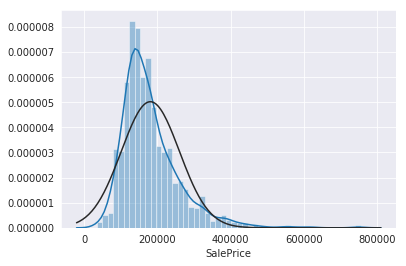

In [7]:
sns.distplot(train_df['SalePrice'] , fit=norm)

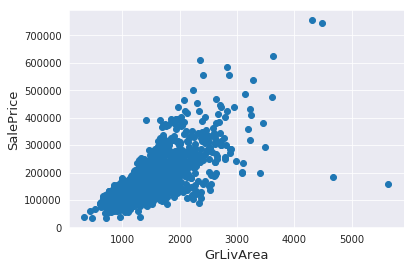

In [10]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

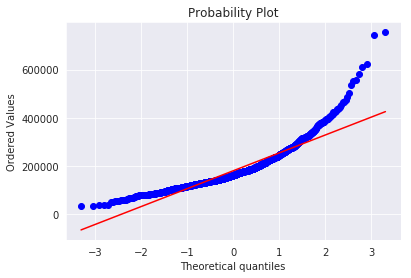

In [15]:
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

columns with missing values
               Missing Ratio
PoolQC               99.657
MiscFeature          96.403
Alley                93.217
Fence                80.439
FireplaceQu          48.647
LotFrontage          16.650
GarageFinish          5.447
GarageYrBlt           5.447
GarageQual            5.447
GarageCond            5.447
GarageType            5.379
BsmtExposure          2.809
BsmtCond              2.809
BsmtQual              2.775
BsmtFinType2          2.741
BsmtFinType1          2.706
MasVnrType            0.822
MasVnrArea            0.788
MSZoning              0.137
BsmtFullBath          0.069
(1460, 75) (1459, 75)
(1460,)
Number of Outliers: 146
Number of rows without outliers: 1314
(1314, 75) (1314,) (1459, 75)


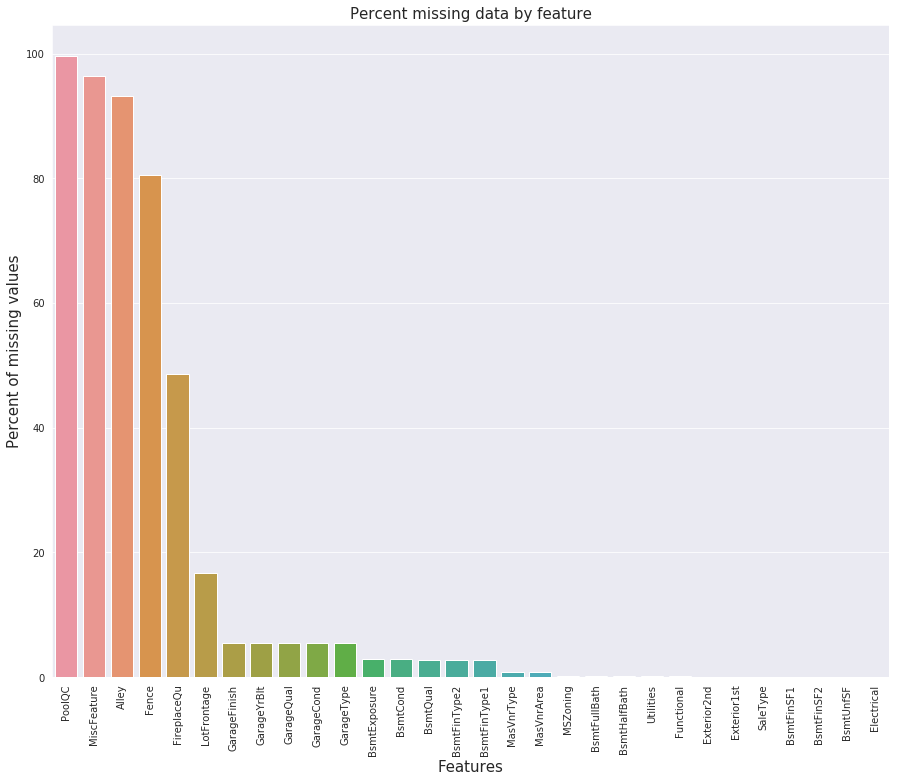

In [17]:
random_state=42
cross_validation_folds = 5
n_jobs = 2
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
test_ids = test_df.Id
y = train_df.SalePrice
train_df.drop(['SalePrice'], inplace=True, axis=1)
combine = [train_df, test_df]
combined = pd.concat([train_df, test_df])
train_df.replace(['NaN', 'NA', 'nan'], np.nan, inplace=True)
test_df.replace(['NaN', 'NA', 'nan'], np.nan, inplace=True)
def fill_column_with_median_value(df, column):
    """
    fill numerical columns with median value
    fill categorial columns with most common values
    """
    if df[column].dtype=='float64':
        median_value = combined[column][combined[column].notnull()].median()
    elif df[column].dtype=='object':
        median_value = combined[column][combined[column].notnull()].mode()[0]
    else:
        print('-- fuck --'* 40)
    df[column] = df[column].fillna(median_value)
def find_columns_with_na_values(df):
    for column in df.columns:
        if df.loc[df[column].isnull()].size>0:
            yield column

# find columns with missing values
all_data = combined
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
print("columns with missing values\n", missing_data.head(20))            
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

for dataset in combine:
    dataset.drop(['Id', 'Alley', 'PoolQC', 'MiscFeature', 'Fence'], inplace=True, axis=1)
    for column in find_columns_with_na_values(dataset):
        fill_column_with_median_value(dataset, column)
categorical_columns = list(filter(lambda col: train_df[col].dtype=='object', list(train_df.columns)))
mapping = dict()
# get the mapping between column labels to values
for column in categorical_columns:
    combined[column] = combined[column].astype('category')
    mapping[column] = dict(zip(combined[column].cat.categories, np.linspace(0, 1, len(combined[column].cat.categories))))
for dataset in combine:
    dataset.replace(mapping, inplace=True)
print(train_df.shape, test_df.shape)

#outliners removal
clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train_df)
y_noano = clf.predict(train_df)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
anomaly_indexes = y_noano[y_noano['Top'] == 1].index.values
train_df = train_df.iloc[anomaly_indexes]
train_df.reset_index(drop = True, inplace = True)
print(y.shape)
y = y.iloc[anomaly_indexes]
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train_df.shape[0])

combined = pd.concat([train_df, test_df])
scaler = MinMaxScaler()
scaler.fit(combined)
train = scaler.transform(train_df)
test = scaler.transform(test_df)
scaler_price = MinMaxScaler()
scaler_price.fit(y.as_matrix().reshape(-1, 1))
Y = scaler_price.transform(y.as_matrix().reshape(-1, 1))
print(train.shape, y.shape, test.shape)

## Define some helper functions for train/test split

In [3]:
seed = 2
np.random.seed(seed)

def train_test_score(model_fn, train, score_fn):
    scores = []
    kfold = KFold(n_splits=5, random_state=seed)
    for train_index, test_index in kfold.split(train):
        X_train, X_test = train[train_index], train[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        model = model_fn()
        model.fit(X_train, pd.DataFrame(y_train).values)
        y_val = model.predict(X_test)
        score = score_fn(y_val, y_test)
        print(f'score = {score}')
        scores.append(score)
    scores = np.array(scores)
    print(f'resutls = {scores}')
    print("Results: mean=%f (std=%f) MSE" % (scores.mean(), scores.std()))
    

def predict_and_submit(model, test, file):
    y_pred = model.predict(test)
    Y_pred = scaler_price.inverse_transform(y_pred.reshape(-1, 1))
    submission = pd.DataFrame({
        "Id": test_ids,
        "SalePrice": Y_pred.reshape(-1)
    })
    submission.to_csv(file, index=False)

In [4]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(300, input_dim=75, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dense(25, kernel_initializer='normal', activation='relu'))
    model.add(Dense(12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
    opt_adam = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=opt_adam)
    return model

In [11]:
seed = 2
np.random.seed(seed)
scores = []
r2_scores = []
kfold = KFold(n_splits=5, random_state=seed)
for train_index, test_index in kfold.split(train):
    X_train, X_test = train[train_index], train[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    model = baseline_model()
    model.fit(X_train, y_train, epochs=150, verbose=0)
    y_val = model.predict(X_test)
    score = mean_squared_error(y_val, y_test)
    r2_sc = r2_score(y_val, y_test)
    print(f'score = {score}, r2_score = {r2_sc}')
    scores.append(score)
    r2_scores.append(r2_sc)
scores = np.array(scores)
r2_scores = np.array(r2_scores)
print(f'resutls = {scores}, r2 results = {r2_scores}')
print("Results for mse: %f (%f)" % (scores.mean(), scores.std()))
print("Results for r2_score: %f (%f)" % (r2_scores.mean(), r2_scores.std()))

score = 0.0019746695253117516, r2_score = 0.9125184332588069
score = 0.0025880593310644955, r2_score = 0.9057861807929951
score = 0.0027800442766520656, r2_score = 0.8635808607027969
score = 0.0017574923639854863, r2_score = 0.9101783415123227
score = 0.0021945715464610975, r2_score = 0.9015304835088473
resutls = [0.00197467 0.00258806 0.00278004 0.00175749 0.00219457], r2 results = [0.91251843 0.90578618 0.86358086 0.91017834 0.90153048]
Results for mse: 0.002259 (0.000378)
Results for r2_score: 0.898719 (0.017968)


In [12]:
model = baseline_model()
model.fit(train, Y, epochs=150, verbose=1)

Epoch 1/150
1314/1314 [==============================] - 2s 1ms/step - loss: 0.1299
Epoch 2/150
1314/1314 [==============================] - 0s 140us/step - loss: 0.1062
Epoch 3/150
1314/1314 [==============================] - 0s 142us/step - loss: 0.0392
Epoch 4/150
1314/1314 [==============================] - 0s 142us/step - loss: 0.0220
Epoch 5/150
1314/1314 [==============================] - 0s 142us/step - loss: 0.0201
Epoch 6/150
1314/1314 [==============================] - 0s 142us/step - loss: 0.0176
Epoch 7/150
1314/1314 [==============================] - 0s 141us/step - loss: 0.0145
Epoch 8/150
1314/1314 [==============================] - 0s 142us/step - loss: 0.0110
Epoch 9/150
1314/1314 [==============================] - 0s 143us/step - loss: 0.0077
Epoch 10/150
1314/1314 [==============================] - 0s 141us/step - loss: 0.0058
Epoch 11/150
1314/1314 [==============================] - 0s 141us/step - loss: 0.0052
Epoch 12/150
1314/1314 [==============================

## Trying stacking

In [14]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = self.meta_model()
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=random_state)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = model()
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred.reshape(-1)
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)
    
def make_lasso():
    return Lasso(alpha =0.0005, random_state=1)

def make_elasticnet():
    return ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)

def make_krr():
    return KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

def make_gradient_boosting():
    GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                       max_depth=4, max_features='sqrt',
                                       min_samples_leaf=15, min_samples_split=10, 
                                       loss='huber', random_state =5)
    return GBoost

def make_linear_regression():
    return LinearRegression()
    
def make_stacked_model():
    stacked_averaged_models = StackingAveragedModels(
        base_models = (make_lasso, make_elasticnet, make_krr, make_gradient_boosting, make_linear_regression),
        meta_model = make_lasso)
    return stacked_averaged_models
print("*** MSE for stacking ***")
train_test_score(make_stacked_model, train, mean_squared_error)
print("*** R2 for stacking ***")
train_test_score(make_stacked_model, train, r2_score)

*** MSE for stacking ***


/Users/kdang/.virtualenvs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score = 0.0018371675268825714
score = 0.002390266025774385
score = 0.0025259174425421448
score = 0.0015508062491095729
score = 0.0020001113419871653
resutls = [0.00183717 0.00239027 0.00252592 0.00155081 0.00200011]
Results: mean=0.002061 (std=0.000357) MSE
*** R2 for stacking ***
score = 0.915290277610436
score = 0.907136060188566
score = 0.8653917580016112
score = 0.9173853606855722
score = 0.9066483071491048
resutls = [0.91529028 0.90713606 0.86539176 0.91738536 0.90664831]
Results: mean=0.902370 (std=0.018978) MSE


In [11]:
stacked_model = make_stacked_model()
stacked_model.fit(train, Y)

/Users/kdang/.virtualenvs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


StackingAveragedModels(base_models=(<function make_lasso at 0x11d11c400>, <function make_elasticnet at 0x11d11cd90>, <function make_krr at 0x11d11c8c8>, <function make_gradient_boosting at 0x11d11c840>),
            meta_model=<function make_linear_regression at 0x11d11c950>,
            n_folds=5)

In [12]:
predict_and_submit(stacked_model, test, "house_price_result_stacked.csv")

In [13]:
! kaggle competitions submit house-prices-advanced-regression-techniques \
-f house_price_result_stacked.csv \
-m "stacked model with base models of (lasso, elastic net, krr, gradient boosting) and stacker as linear regression"

Successfully submitted to House Prices: Advanced Regression Techniques